# Markov Decision Processeses via Policy Gradients

The goal of this notebook is to solve a simple reinforcement learning problem via policy gradients. In particular, we would
like to find the best path from 0 to 7 in this graph:

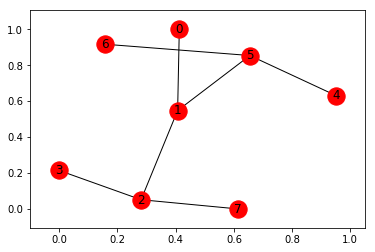

In [29]:
import networkx as nx
points_list = [(0,1), (1,5), (5,6), (5,4), (1,2), (2,3), (2,7)]
G=nx.Graph()
G.add_edges_from(points_list)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos)
nx.draw_networkx_edges(G,pos)
nx.draw_networkx_labels(G,pos)
plt.show()

### Background
Our goal is to find a sequence of actions, denote by policty $\pi$ to maximize the total reward: $$\mathbb{E}[R \lvert \pi] = \int p(\tau \lvert \pi) R(\tau)$$
    
 where $ \tau$ is the space of all *paths*, ie
 $$ \tau = (a_0,s_0,r_0,a_1,s_1,r_1,\cdots,a_t,s_t,r_t)$$
 
 
Now from the **Markov property** we have $$p(\tau \lvert \pi) = \prod_{t=1}^{T-1} p(s_{t+1}\lvert s_t,a_t) \pi (a_t \lvert s_t).$$

We will assume that $$\pi(a_t \lvert s_t)$$ is some stochastic policy, which has a form of

$$ \pi (a_t \lvert s_t) = \frac{e^{-\theta_{s_t,s_{t-1}}}}{\sum_k e^{-\theta_{s_t,s_k}}}$$
** The policy gradient trick: **

Observe that
$$
\begin{align}
\nabla_{\theta} \mathbb{E}[R \lvert \pi] &= \int \nabla_{\theta} p (\tau \lvert \pi) R(\tau) \\
&= \int \frac{\nabla_{\theta} p(\tau \lvert \pi)}{p(\tau \lvert \pi)} p(\tau \lvert \pi) R(\tau)\\
&= \mathbb{E}_p\left[ \nabla_{\theta} \log p(\tau \lvert \pi) R(\tau)\right]
\end{align}
$$

In other words, we can write this as an expectation once again, and therefore use samples from our data! But even more importantly:

$$
\begin{align}
\log p(\tau \lvert \pi) &= \log \prod_{t=1}^{T-1} p(s_{t+1}\lvert s_t,a_t) \pi (a_t \lvert s_t)\\
&=\sum_{t=1}^{T-1} \log p(s_{t+1} \lvert s_t,a_t) + \sum \log \pi(a_t \lvert s_t)
\end{align}
$$

The amazing thing here is that while our policy depends on our choice of $\theta_{s_{t},s_{t-1}}$, $p(s_{t+1} \lvert s_t,a_t)$ does not! 


## Our setting

In our case, we have 7 nodes labeled $k=0,1,\cdots,7$ and we make the softmax prior:

$$  \pi (k \lvert m ) = \frac{e^{-\theta_{k,m}}}{\sum_k e^{-\theta_{k,m}}},$$
which is the transition probability of going from node m to node k. How do we define the rewards?

**Choice of Reward:**
- We want to have a negative reward when we hit a barrier - ie. there is no edge in the graph. We set the reward in this case to be $-1$.
- We want to favor possible directions (even if they haven't lead to the reward yet). So we set the reward to be $1$ if the edge exists. 
- We define a reward of $100$ if our path reaches the goal: node 7.

In [28]:
# how many points in graph? x points
MATRIX_SIZE = 8

# create matrix x*y
R = np.matrix(np.ones(shape=(MATRIX_SIZE, MATRIX_SIZE)))
R *= -1

# assign zeros to paths and 100 to goal-reaching point
for point in points_list:
    print(point)
    if point[1] == goal:
        R[point] = 100
    else:
        R[point] = 0

    if point[0] == goal:
        R[point[::-1]] = 100
    else:
        # reverse of point
        R[point[::-1]]= 0

# add goal point round trip
R[goal,goal]= 100

R

(0, 1)
(1, 2)
(2, 7)


matrix([[  -1.,    0.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.],
        [   0.,   -1.,    0.,   -1.,   -1.,   -1.,   -1.,   -1.],
        [  -1.,    0.,   -1.,   -1.,   -1.,   -1.,   -1.,  100.],
        [  -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.,   -1.],
        [  -1.,   -1.,    0.,   -1.,   -1.,   -1.,   -1.,  100.]])

# The Algorithm



### Step 1: Initializiation


We assume that we can go in any direction, so we assume that $\theta_{km} \equiv 0$, giving equal probability to each direction.


In [18]:
# Initialize Weights
theta = np.matrix(np.zeros(shape=(8,8)))
theta

matrix([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

We define the corresponding probabilites based on $\theta$, which, as expected are uniform across possible paths


In [21]:
# Initialize Weights to be learned
for k in range(8):
    W[k]=softmax(theta[k].squeeze())
W

matrix([[ 0.125,  0.125,  0.125,  0.125,  0.125,  0.125,  0.125,  0.125],
        [ 0.125,  0.125,  0.125,  0.125,  0.125,  0.125,  0.125,  0.125],
        [ 0.125,  0.125,  0.125,  0.125,  0.125,  0.125,  0.125,  0.125],
        [ 0.125,  0.125,  0.125,  0.125,  0.125,  0.125,  0.125,  0.125],
        [ 0.125,  0.125,  0.125,  0.125,  0.125,  0.125,  0.125,  0.125],
        [ 0.125,  0.125,  0.125,  0.125,  0.125,  0.125,  0.125,  0.125],
        [ 0.125,  0.125,  0.125,  0.125,  0.125,  0.125,  0.125,  0.125],
        [ 0.125,  0.125,  0.125,  0.125,  0.125,  0.125,  0.125,  0.125]])

### Step 2: Choose a stochastic policy

In our setting if are at node $k(t)$ at time t, then $$a_{k(t)} \sim \textrm{Mult}\left(\pi_{0k},\cdots,\pi_{7k}\right)$$

We do this in Python via:

In [24]:
s_next = np.where(np.random.multinomial(1, np.array(W[s_current,:]).squeeze(), size=1)==1)[1][0]

### Step 2: Oberve reward and update parameters in *good* directions

Thus we want to find the best path. At each observation we want to **gradient descent** in the direction of best gradient:

    ie. 
   $$ \theta_{km}^t= \theta_{km}^{t-1} - R(t) \nabla_{\theta} \log \pi (k \lvert m) $$
   
For this we do a simple computation:

$$ \log \pi (k \lvert m) = - \theta_{km} - \log \left( \sum_l e^{-\theta_{lm}}\right).$$


Thus 
$$ \nabla_{\theta_{km}} \log \pi (k \lvert m) = \pi(k \lvert m) - 1,$$

a relative simple equation!


We implement it as `gradient` below:

In [22]:
def gradient(k,m,alpha=0.1):
    #denom = sum([np.exp(-theta[k,l]) for l in range(8)])
    return R[k,m]*(W[k,m]-1)

In [23]:
def softmax(t):
    return np.exp(-t)/np.sum(np.exp(-t))

We see here that we want to nudge the parameters in the *good* directions - ie. the one with highest payoffs. This is very 
analogous to importance sampling

## Step 3: Keep on iterating and learning

We now show the full code below which initializes uniform weights then does 100 iterations of exploring the graph. The 
shortest path is then recorded as the "best" path and plotted below.

Found best path [(0, 1), (1, 2), (2, 7)] after 6 simulations


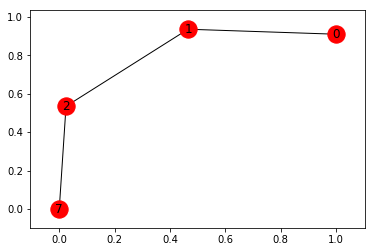

In [27]:
s_current = 0
# Initialize Weights
W = np.matrix(np.ones(shape=(8,8)))
#W *= 1/8

# Initialize Weights
theta = np.matrix(np.zeros(shape=(8,8)))

# Initialize Weights to be learned
for k in range(8):
    W[k]=softmax(theta[k].squeeze())
    
    
    
best_path=[]
best_length=1000
found_after = 0
for simulation in range(100):
    s_current = 0
    # Initialize Weights
    theta = np.matrix(np.zeros(shape=(8,8)))

    # Initialize Weights to be learned
    for k in range(8):
        W[k]=softmax(theta[k].squeeze())
    path=[]
    for t in range(10):
        reward=-1
        while reward < 0:
            s_next = np.where(np.random.multinomial(1, np.array(W[s_current,:]).squeeze(), size=1)==1)[1][0]
            reward = R[s_current,s_next]

        path.append((s_current,s_next))
        if reward == 100:
            if len(path) < best_length:
                best_path = path
                best_length=len(best_path)
                found_after = simulation
                break
        #print (s_current,s_next,R[s_current,s_next])

        reward_next = R[s_current,s_next]
        #print (s_next)
        for m in range(8):
            theta[s_current,m] = theta[s_current,m] + gradient(s_current,m,alpha=0.01)
        for k in range(8):
            W[k]=softmax(theta[k].squeeze())
        s_current = s_next
    
print ("Found best path " + str(best_path) + " after " + str(found_after) + " simulations")



# map cell to cell, add circular cell to goal point
points_list = best_path
goal = 7


G=nx.Graph()
G.add_edges_from(points_list)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos)
nx.draw_networkx_edges(G,pos)
nx.draw_networkx_labels(G,pos)
plt.show()

